# Trading Strategy Design
This file is aimed to practice, train and learn from designing the first few trading strategies in this project. 

In [1]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append('/Users/zway/Desktop/BTC_Project/Crypto_Research/features')
from trend_indicator_pipeline_pkg import MovingAveragePipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline

from arcticdb.version_store.helper import ArcticMemoryConfig

from arcticdb import Arctic

In [2]:
# Load files
df = pd.read_csv('/Users/zway/Desktop/BTC_Project/raw_datasets/BTCUSD_1m_2023.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# DB path
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

In [3]:
# indicators simplify
trend = MovingAveragePipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
momentum = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
volatility = VolatilityIndicatorPipeline(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")

20250706 22:46:36.910926 16312983 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[65336]
20250706 22:46:36.913366 16312983 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[65336]


## 1st Strategy
Indicators: SMA, EMA, RSI, MACD and Bollinger Bands

### Entry Signal
Price above EMA 20 (uptrend)

MACD > MACD Signal (positive momentum)

RSI > 50 (strong buying pressure)

Price touches or crosses above the Lower Bollinger Band (volatility cue)

### Exit Signal
Price drops below EMA 20

OR MACD < MACD Signal

OR RSI < 45

OR Price touches or crosses below Upper Bollinger Band



In [4]:
# Set up indicators

#EMA
df = trend.compute_ema(df, days = 20)

# MACD - Standard: fast_days=12, slow_days=26, signal_days=9
df = momentum.compute_macd(df, 12, 26, 9)
df.rename(columns={
    'macd': 'macd_12_26',
    'macd_signal': 'macd_sig_12_26',
    'macd_diff': 'macd_hist_12_26'
}, inplace=True)

# RSI
df = momentum.compute_rsi(df, days=14)

# Bollinger Bands
df = volatility.compute_bollinger_bands(df, days=20, std=2)

In [12]:
# Strategy Setup
def run_strategy(df, initial_cash=10000):
    cash = initial_cash
    position = 0
    entry_price = 0
    portfolio = []
    signals = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]

        # Entry condition
        if position == 0:
            if (
                row['Close'] > row['ema_20d']
                and row['macd_12_26'] > row['macd_sig_12_26']
                and row['rsi_14d'] > 50
                and row['Close'] <= row['bb_lower_20d']
            ):
                position = cash / row['Close']
                entry_price = row['Close']
                cash = 0
                signals.append((row.name, 'Buy', row['Close']))

        # Exit condition
        elif position > 0:
            if (
                row['Close'] < row['ema_20d']
                or row['macd_12_26'] < row['macd_sig_12_26']
                or row['rsi_14d'] < 45
                or row['Close'] >= row['bb_upper_20d']
            ):
                cash = position * row['Close']
                position = 0
                signals.append((row.name, 'Sell', row['Close']))

        total_value = cash if position == 0 else position * row['Close']
        portfolio.append(total_value)

    df = df.iloc[1:].copy()
    df['portfolio_value'] = portfolio
    return df, signals


In [9]:
# Visualize Portfolio & Signals
def plot_portfolio(df, signals):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['portfolio_value'], label='Portfolio Value')
    plt.plot(df.index, df['Close'], label='BTC Price', alpha=0.5)

    for ts, signal, price in signals:
        if signal == 'Buy':
            plt.scatter(ts, price, color='green', marker='^', label='Buy Signal')
        elif signal == 'Sell':
            plt.scatter(ts, price, color='red', marker='v', label='Sell Signal')

    plt.title('BTC/USD Strategy Backtest')
    plt.xlabel('Timestamp')
    plt.ylabel('USD')
    plt.legend()
    plt.tight_layout()
    plt.show()

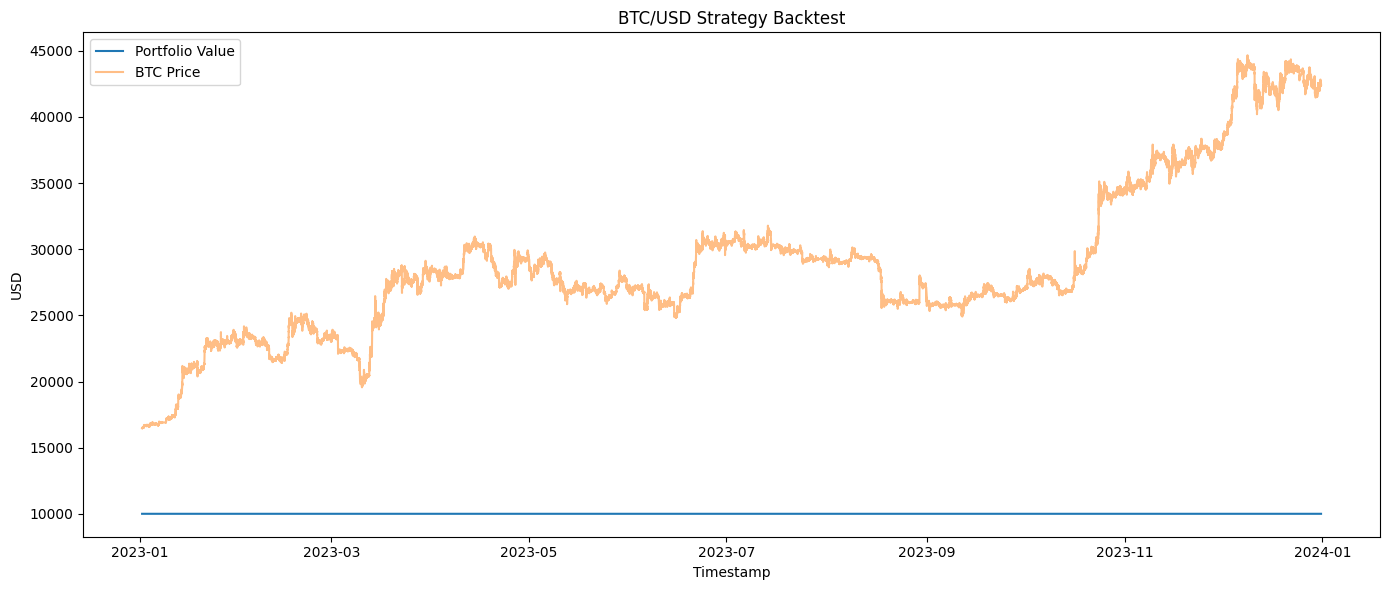

In [13]:
# Run the strategy
result_df, trade_signals = run_strategy(df)

# Plot results
plot_portfolio(result_df, trade_signals)

## Result & Common
There is no trade has been executed, the strategy's entry condition was too restrictive or rarely satisfied over the dataset.

## 2nd Strategy - Aggressive Entry Strategy
Indicators: SMA, EMA, RSI, MACD and Bollinger Bands

### Entry Signal
Price above EMA 20 (uptrend)

MACD histogram > 0 (positive momentum)

RSI > 45 (strong buying pressure)


### Exit Signal
Price drops below EMA 20

OR MACD < MACD Signal

OR RSI < 45

OR Price touches or crosses below Upper Bollinger Band

In [16]:
# Aggressive-1 Strategy Setup
def run_agg_strategy(df, initial_cash=10000):
    cash = initial_cash
    position = 0
    entry_price = 0
    portfolio = []
    signals = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]

        # Entry condition
        if position == 0:
            if (
                row['Close'] > row['ema_20d']
                and row['macd_hist_12_26'] > 0
                and row['rsi_14d'] >= 45
            ):
                position = cash / row['Close']
                entry_price = row['Close']
                cash = 0
                signals.append((row.name, 'Buy', row['Close']))

        # Exit condition
        elif position > 0:
            if (
                row['Close'] < row['ema_20d']
                or row['macd_12_26'] < row['macd_sig_12_26']
                or row['rsi_14d'] < 45
                or row['Close'] >= row['bb_upper_20d']
            ):
                cash = position * row['Close']
                position = 0
                signals.append((row.name, 'Sell', row['Close']))

        total_value = cash if position == 0 else position * row['Close']
        portfolio.append(total_value)

    df = df.iloc[1:].copy()
    df['portfolio_value'] = portfolio
    return df, signals


In [17]:
# Run the strategy
result_df, trade_signals = run_agg_strategy(df)

# Plot results
plot_portfolio(result_df, trade_signals)

/var/folders/17/9z6k3ymn2q36ng2sbdl_60zh0000gn/T/ipykernel_81846/3388497894.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/17/9z6k3ymn2q36ng2sbdl_60zh0000gn/T/ipykernel_81846/3388497894.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/opt/anaconda3/envs/de_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1178x786517 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x600 with 1 Axes>

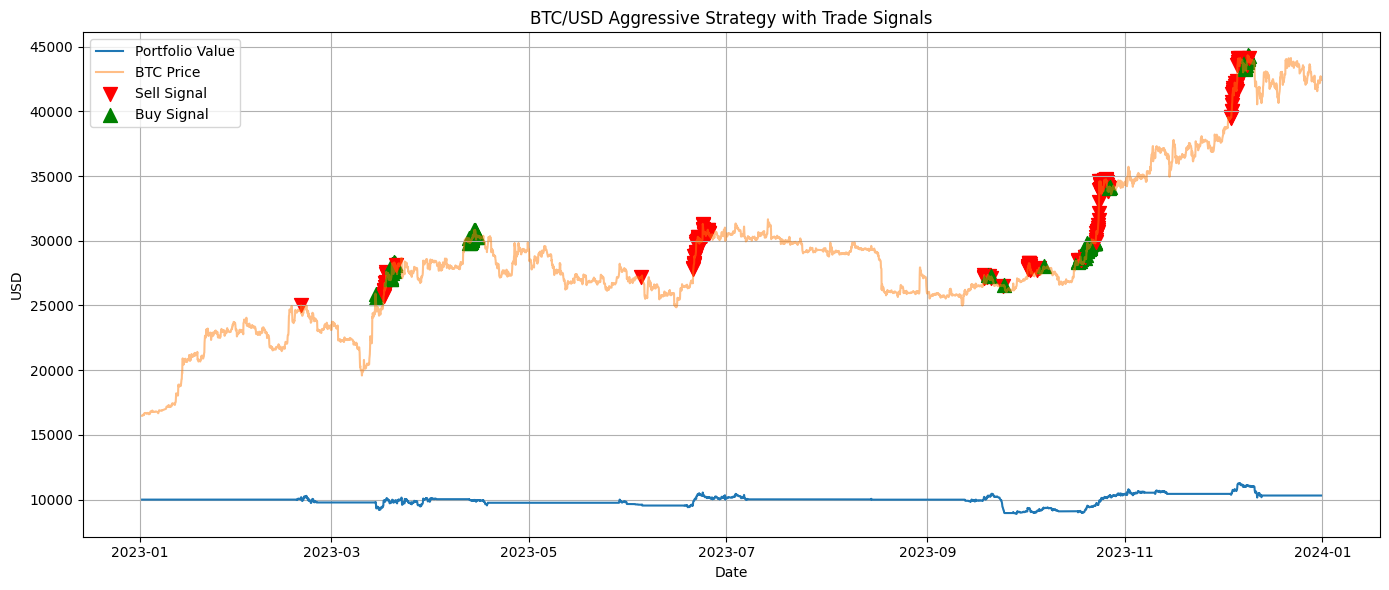

In [20]:
plot_df = result_df.iloc[::100, :]         # Downsample for plotting

plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['portfolio_value'], label='Portfolio Value')
plt.plot(plot_df.index, plot_df['Close'], label='BTC Price', alpha=0.5)

# Add Buy/Sell markers
for ts, action, price in trade_signals:
    if ts in plot_df.index:
        if action == 'Buy':
            plt.scatter(ts, price, marker='^', color='green', s=100, label='Buy Signal')
        elif action == 'Sell':
            plt.scatter(ts, price, marker='v', color='red', s=100, label='Sell Signal')

# Deduplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Final plot config
plt.title('BTC/USD Aggressive Strategy with Trade Signals')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def summarize_portfolio(df, signals, initial_cash=10000, periods_per_year=252):
    final_value = df['portfolio_value'].iloc[-1]
    returns = df['portfolio_value'].pct_change().dropna()

    # Basic stats
    profit = final_value - initial_cash
    total_return = profit / initial_cash
    n_trades = len([s for s in signals if s[1] == 'Buy'])

    # Win rate
    profits = []
    in_trade = False
    for i, (ts, action, price) in enumerate(signals):
        if action == 'Buy':
            entry = price
            in_trade = True
        elif action == 'Sell' and in_trade:
            profits.append(price - entry)
            in_trade = False
    win_rate = np.mean([p > 0 for p in profits]) if profits else np.nan

    # Sharpe ratio
    sharpe = (returns.mean() / returns.std()) * np.sqrt(periods_per_year) if not returns.empty else np.nan

    # Max drawdown
    peak = df['portfolio_value'].cummax()
    drawdown = (df['portfolio_value'] - peak) / peak
    max_drawdown = drawdown.min()

    # Display
    summary = {
        'Initial Capital': f'${initial_cash:,.2f}',
        'Final Portfolio Value': f'${final_value:,.2f}',
        'Net Profit': f'${profit:,.2f}',
        'Total Return': f'{total_return:.2%}',
        'Number of Trades': n_trades,
        'Win Rate': f'{win_rate:.2%}' if not np.isnan(win_rate) else 'N/A',
        'Max Drawdown': f'{max_drawdown:.2%}' if not np.isnan(max_drawdown) else 'N/A',
        'Sharpe Ratio': f'{sharpe:.2f}' if not np.isnan(sharpe) else 'N/A'
    }

    for k, v in summary.items():
        print(f'{k:25s}: {v}')

In [22]:
summarize_portfolio(result_df, trade_signals)

Initial Capital          : $10,000.00
Final Portfolio Value    : $10,315.71
Net Profit               : $315.71
Total Return             : 3.16%
Number of Trades         : 18774
Win Rate                 : 50.45%
Max Drawdown             : -16.05%
Sharpe Ratio             : 0.01


## Result & Comments
### Portfolio Snapshot
The trade strategy is working but the gain is marginal. The return rate does not beat federal rate, and the sharpe ratio is very low, which implies that the earning is properly brought by noise instead of true earning. Considering the BTC price has increase drastically in this 1 year period. This result is unacceptable. 

### Thoughts
#### Unrealistic Frequent Trade
The numbers of trade is 18774, and on the graph, we can find the trading signals, whether entry/exit are very condensed. The strategy is frequently been triggered on low signals.

#### Short Holding Period
BTC rallied from ~$17K → ~$42K, but the portfolio grew just 3.16%. Based on the graph, I think this may be caused by short holding period and whipsaws(frequent buy/sell with no profit)

#### Risk
The Sharpe Ratio is 0.01, which means returns are mostly noise, not a signal-driven edge. It is not meaningful to discuss the risk here.

### Future Improvement
#### Debounce Trading Frequency
- Enforce a minimum holding period for now, just to test: Add a flag: hold_counter += 1 and don't allow exits before hold_counter >= N

#### Filter Entry Signals
- Add SMA confirmation (e.g., EMA_20 > SMA_50)

- Add RSI slope check: RSI must be rising for buy signal

- Ensure MACD histogram is increasing (macd_hist[t] > macd_hist[t-1])

#### Add Stop Loss / Take Profit
Example: Exit if price drops >5% or gains >10% since entry

Improves drawdown control and lets winners run


## 3rd Strategy - Aggressive Strategy v2
### 1. Entry Conditions (Stronger Confirmation)
Close > ema_20d

ema_20d > sma_50d ← trend filter

macd_hist_12_26 > 0 and rising

rsi_14d > 45 and rising

### 2. Exit Conditions (Exit Early or on Signals)
Close < ema_20d

or macd_hist_12_26 < 0

or rsi_14d < 40

or Close > bb_upper_20d

or stop-loss or take-profit triggers

### 3. Add Risk Controls
Minimum hold time: 5 periods (e.g. candles)

Stop Loss: Exit if price drops 5% from entry

Take Profit: Exit if price rises 10% from entry



In [5]:
df = trend.compute_sma(df, days = 50)

In [24]:
def run_agg_strategy_v2(df, initial_cash=10000, hold_period=5, sl_pct=0.05, tp_pct=0.10):
    cash = initial_cash
    position = 0
    entry_price = 0
    hold_counter = 0
    portfolio = []
    signals = []
    in_trade = False

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]

        # Entry
        if not in_trade:
            if (
                row['Close'] > row['ema_20d']
                and row['ema_20d'] > row['sma_50d']
                and row['macd_hist_12_26'] > 0 and row['macd_hist_12_26'] > prev['macd_hist_12_26']
                and row['rsi_14d'] > 45 and row['rsi_14d'] > prev['rsi_14d']
            ):
                position = cash / row['Close']
                entry_price = row['Close']
                hold_counter = 0
                cash = 0
                in_trade = True
                signals.append((row.name, 'Buy', row['Close']))

        # Exit
        elif in_trade:
            hold_counter += 1
            price_change = (row['Close'] - entry_price) / entry_price

            exit_conditions = [
                row['Close'] < row['ema_20d'],
                row['macd_hist_12_26'] < 0,
                row['rsi_14d'] < 40,
                row['Close'] > row['bb_upper_20d'],
                price_change <= -sl_pct, # price drops below stop loss percentage
                price_change >= tp_pct,  # price raises above take profit percentage
                hold_counter >= hold_period
            ]

            if any(exit_conditions):
                cash = position * row['Close']
                position = 0
                in_trade = False
                signals.append((row.name, 'Sell', row['Close']))

        total_value = cash if not in_trade else position * row['Close']
        portfolio.append(total_value)

    df = df.iloc[1:].copy()
    df['portfolio_value'] = portfolio
    return df, signals


In [25]:
df_v2, signals_v2 = run_agg_strategy_v2(df)

In [26]:
summarize_portfolio(df_v2, signals_v2)

Initial Capital          : $10,000.00
Final Portfolio Value    : $15,253.87
Net Profit               : $5,253.87
Total Return             : 52.54%
Number of Trades         : 10798
Win Rate                 : 52.70%
Max Drawdown             : -4.96%
Sharpe Ratio             : 0.11


In [6]:
def plot_full_strategy(df, signals, title='BTC/USD Aggressive-2 Strategy'):
    df = df.copy()
    buy_signals = [s for s in signals if s[1] == 'Buy']
    sell_signals = [s for s in signals if s[1] == 'Sell']

    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]})

    # ---- 1. Price + Portfolio + Buy/Sell ----
    ax = axes[0]
    ax.plot(df.index, df['Close'], label='BTC Price', color='orange', alpha=0.6)
    ax.plot(df.index, df['portfolio_value'], label='Portfolio Value', color='blue')
    ax.plot(df.index, df['ema_20d'], label='EMA 20d', linestyle='--', color='green')
    ax.plot(df.index, df['sma_50d'], label='SMA 50d', linestyle='--', color='purple')
    ax.plot(df.index, df['bb_upper_20d'], label='Bollinger Upper', linestyle=':', color='gray')

    for ts, action, price in buy_signals:
        if ts in df.index:
            ax.scatter(ts, price, marker='^', color='green', s=80, label='Buy Signal')
    for ts, action, price in sell_signals:
        if ts in df.index:
            ax.scatter(ts, price, marker='v', color='red', s=80, label='Sell Signal')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_title(title)
    ax.set_ylabel('USD')
    ax.grid(True)

    # ---- 2. MACD Histogram ----
    axes[1].bar(df.index, df['macd_hist_12_26'], label='MACD Histogram', color='gray')
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].legend()
    axes[1].set_ylabel('MACD Hist')
    axes[1].grid(True)

    # ---- 3. RSI ----
    axes[2].plot(df.index, df['rsi_14d'], label='RSI 14d', color='brown')
    axes[2].axhline(70, color='red', linestyle='--')
    axes[2].axhline(30, color='green', linestyle='--')
    axes[2].axhline(50, color='black', linestyle=':')
    axes[2].legend()
    axes[2].set_ylabel('RSI')
    axes[2].grid(True)

    # ---- 4. Portfolio Value Only ----
    axes[3].plot(df.index, df['portfolio_value'], label='Portfolio Value', color='blue')
    axes[3].legend()
    axes[3].set_ylabel('USD')
    axes[3].set_xlabel('Date')
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()


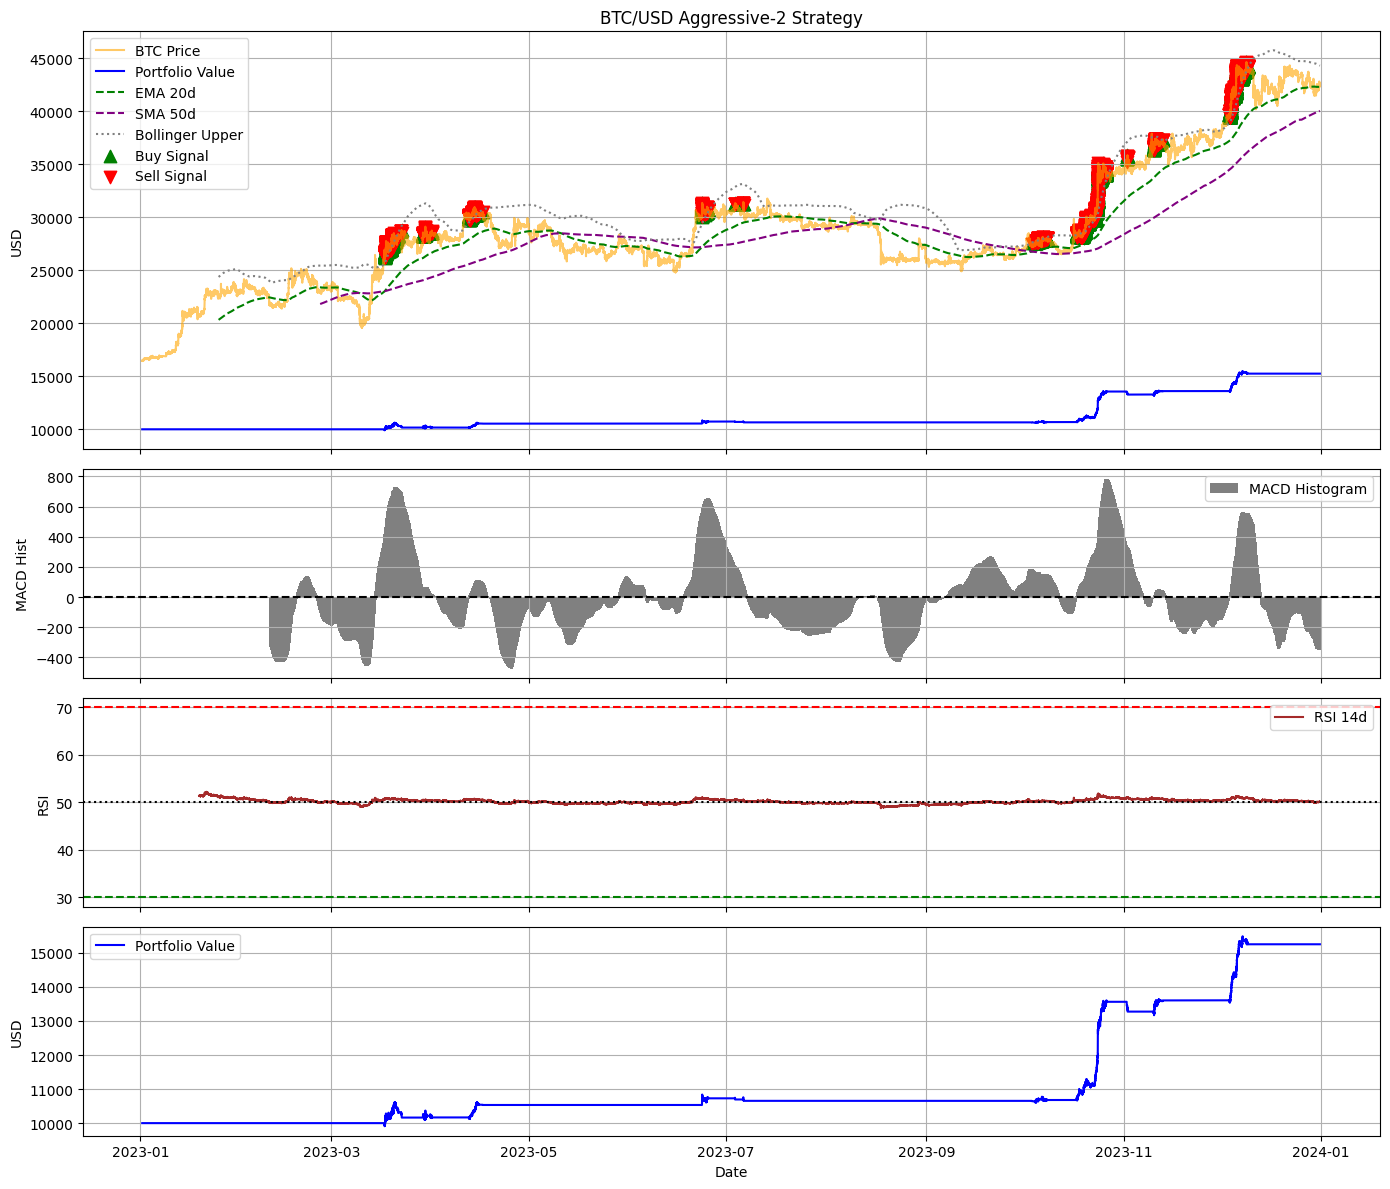

In [28]:
plot_full_strategy(df_v2, signals_v2)

## v2 Strategy Result & Comments
### Portfolio Snapshot
Initial Capital          : $10,000.00

Final Portfolio Value    : $15,253.87

Net Profit               : $5,253.87

Total Return             : 52.54%

Number of Trades         : 10798

Win Rate                 : 52.70%

Max Drawdown             : -4.96%

Sharpe Ratio             : 0.11

--------------------------------------------------------------------------------------------------------

Drawdown: Cut from −16% to −5% — major risk improvement.

Win Rate: Slightly increased, confirming better signal quality.

Trade Timing: Portfolio value rises during uptrends — strategy is participating.

### Thoughts
#### Frequent Trades
The trade frequency is still relatively high. This phenomenon may be caused by signal jitter or short holding period. In real market, these trades may cause high transaction fees and seriously affect the return.

However, frequent trades may not direct mean negative result. We need to record the trade log and analyze each trade's PnL. Considering the sample BTC period is mostly upward, holding for a long-term is definitely a positive strategy, however, in a more fluctuated market, this strategy may bring less profit. Therefore, we may need to think of to make a short-term and high-frequency trading strategy or a long-term strategy, or we develop a tool to switch between strategies.

### Future Improvements
#### Trade log & Track PnL per Trade
Create trade log with: Buy time / Sell time, Entry price / Exit price, Return per trade, Duration

#### Position Sizing
Use fractional size, scale in/out to balance short-term and high-frequency trading and long-term investment

Add capital exposure tracking (e.g., % of portfolio invested)

#### Add Fee Simulation
Simulate a fixed fee or 0.1% per trade based on most common BTC market

Encourage fewer and less frequent trades

## v2 Strategy Trade Log & Analysis


In [29]:
def build_trade_log(signals, df, initial_cash=10000):
    trades = []
    in_trade = False
    entry_time = entry_price = exit_time = exit_price = 0
    position_size = 0

    for ts, action, price in signals:
        if action == 'Buy' and not in_trade:
            entry_time = ts
            entry_price = price
            in_trade = True
            position_size = initial_cash / entry_price  # Assume full allocation

        elif action == 'Sell' and in_trade:
            exit_time = ts
            exit_price = price
            duration = (df.index.get_loc(exit_time) - df.index.get_loc(entry_time))

            pnl = (exit_price - entry_price) * position_size
            return_pct = (exit_price - entry_price) / entry_price * 100

            trades.append({
                'Entry Time': entry_time,
                'Entry Price': entry_price,
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'Duration': duration,
                'Return (%)': round(return_pct, 2),
                'PnL ($)': round(pnl, 2)
            })

            in_trade = False

    return pd.DataFrame(trades)


In [35]:
trade_log_df = build_trade_log(signals_v2, df_v2)

In [37]:
print(trade_log_df.head())

print('Total Trades:', len(trade_log_df))
print('Average PnL ($):', trade_log_df['PnL ($)'].mean())
print('Average Return (%):', trade_log_df['Return (%)'].mean())
print('Winning Trades:', (trade_log_df['PnL ($)'] > 0).sum())
print('Losing Trades:', (trade_log_df['PnL ($)'] < 0).sum())

           Entry Time  Entry Price           Exit Time  Exit Price  Duration  \
0 2023-03-17 12:05:00      26848.8 2023-03-17 12:06:00     26797.8         1   
1 2023-03-17 12:11:00      26768.8 2023-03-17 12:12:00     26752.0         1   
2 2023-03-17 12:15:00      26724.2 2023-03-17 12:16:00     26693.4         1   
3 2023-03-17 12:19:00      26720.9 2023-03-17 12:20:00     26711.8         1   
4 2023-03-17 12:21:00      26732.2 2023-03-17 12:22:00     26681.5         1   

   Return (%)  PnL ($)  
0       -0.19   -19.00  
1       -0.06    -6.28  
2       -0.12   -11.53  
3       -0.03    -3.41  
4       -0.19   -18.97  
Total Trades: 10798
Average PnL ($): 0.39491757732913507
Average Return (%): 0.003934987960733469
Winning Trades: 5691
Losing Trades: 5047


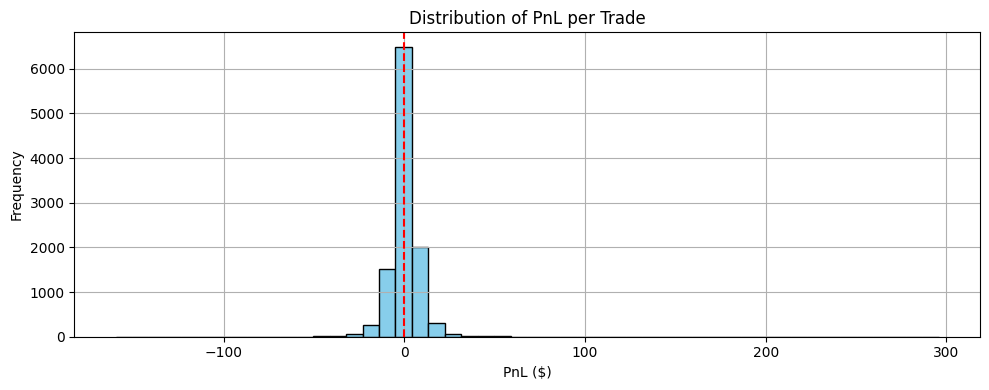

In [38]:
plt.figure(figsize=(10, 4))
plt.hist(trade_log_df['PnL ($)'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of PnL per Trade')
plt.xlabel('PnL ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

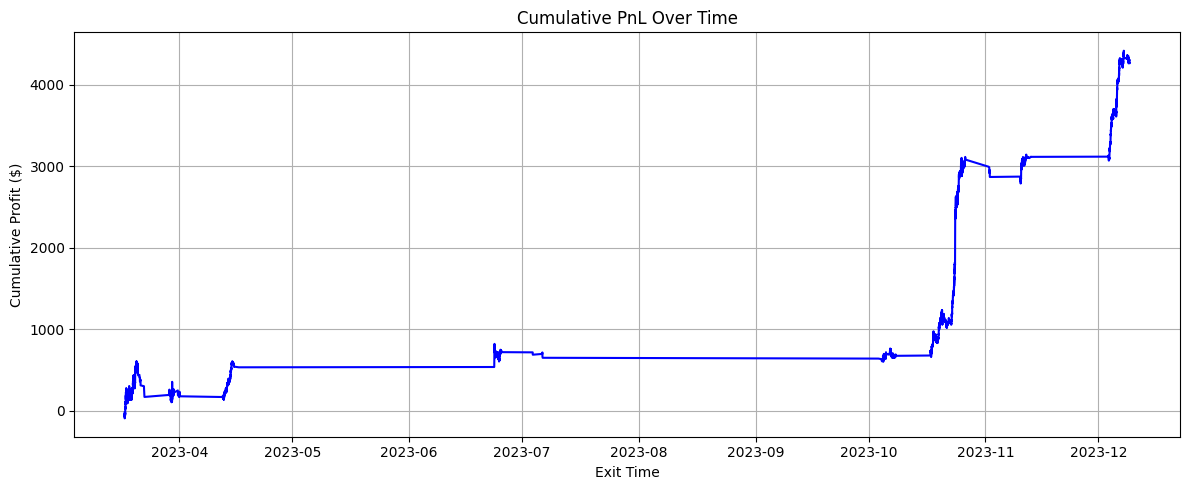

In [39]:
# PnL over time plot
# Ensure datetime format
trade_log_df['Exit Time'] = pd.to_datetime(trade_log_df['Exit Time'])

# Sort by exit time (just in case)
trade_log_df = trade_log_df.sort_values('Exit Time').reset_index(drop=True)

# Calculate cumulative PnL
trade_log_df['Cumulative PnL ($)'] = trade_log_df['PnL ($)'].cumsum()

plt.figure(figsize=(12, 5))
plt.plot(trade_log_df['Exit Time'], trade_log_df['Cumulative PnL ($)'], color='blue')
plt.title('Cumulative PnL Over Time')
plt.xlabel('Exit Time')
plt.ylabel('Cumulative Profit ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

## v2 Strategy Trade Log Analysis
### Overall Insights
Majority of trades are centered around $0. There are a few outlier gains/losses. But the bulk of trades cluster tightly around breakeven

Pros:

Strategy is consistently profitable over thousands of trades.

The win rate > 50% suggests the signal logic is valid.

The drawdown and risk are well controlled.

Cons:

Most trades are too small to matter — $0.39/trade barely offsets transaction fees.

1-minute duration is too reactive - high execution cost in reality.

Returns are not fat-tailed enough - the return is more likely to be brought by the BTC appreciate instead of the strategy gains.

### Next Steps
#### Simulate Trading Cost
Simulate the transaction fee, and forced the strategy to trade only when the gain is greater than fee. This threshold may discourage frequent but low quality trade.

#### Add Trade Reason Logging
Include a column like 'Exit Reason': e.g., 'SL', 'TP', 'Signal'. Aimed to help me diagnose if you’re getting stopped out prematurely

#### Introduce Trade Filtering
Only enter when:

RSI is rising and MACD histogram is steepening

Price is significantly above SMA or volatility is expanding

## RSI Analysis
Based on the graph above, I found that the RSI-14d is not moving obviously. Considering that RSI is an important indicator in entry/exit strategy, we need to study this case, and if we want to stick with short-term trading, we may need a faster RSI.

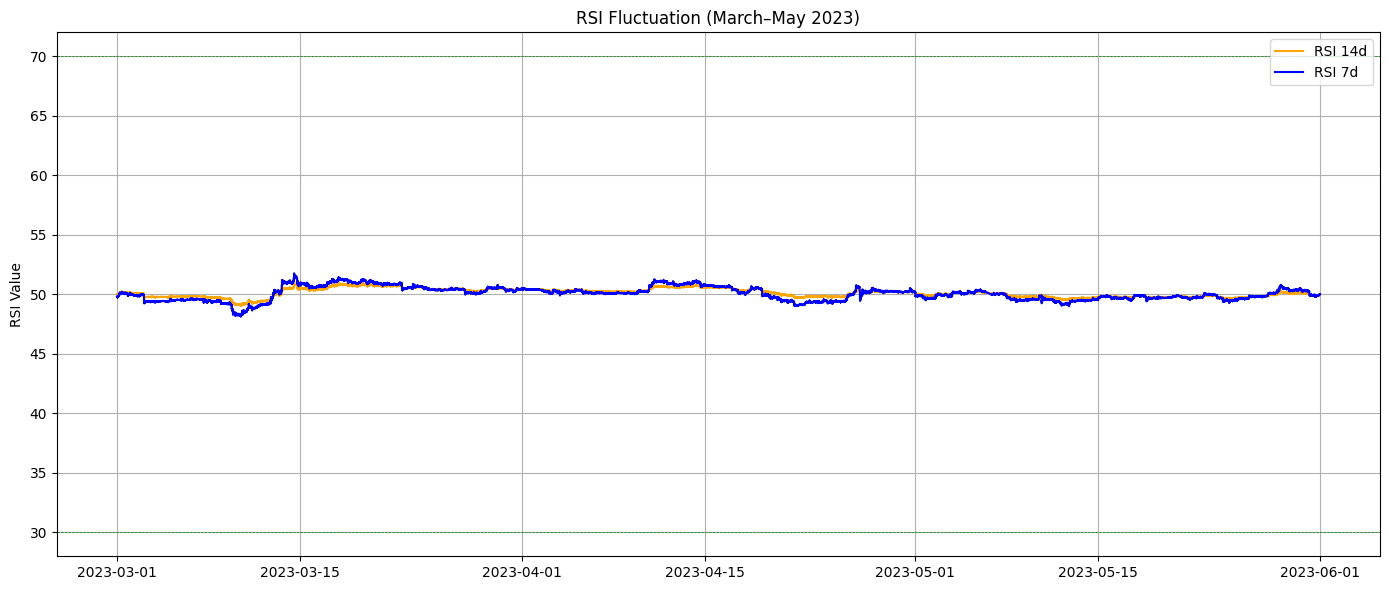

In [42]:
df_rsi = momentum.compute_rsi(df, days = 7)
df_rsi = momentum.compute_rsi(df, days = 14)

# Define the focus window
focus_start = '2023-03-01'
focus_end = '2023-05-31'
focus_df = df.loc[focus_start:focus_end].copy()

# Recalculate std over local window
focus_df['rsi_14d_std'] = focus_df['rsi_14d'].rolling(window=20).std()
focus_df['rsi_7d_std'] = focus_df['rsi_7d'].rolling(window=20).std()

# Plot focused RSI and its std
plt.figure(figsize=(14, 6))
# Plot RSI values
plt.plot(focus_df.index, focus_df['rsi_14d'], label='RSI 14d', color='orange')
plt.plot(focus_df.index, focus_df['rsi_7d'], label='RSI 7d', color='blue')

plt.axhline(70, color='green', linestyle='--', linewidth=0.5)
plt.axhline(30, color='green', linestyle='--', linewidth=0.5)
plt.title('RSI Fluctuation (March–May 2023)')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## v3 Strategy
### 1. Transaction Fee Simulation
Robinhood BTC fee: 0.75% per trade

Deduct fee from cash on buy and sell

### 2. Trade Log with Detail
Entry Time, Exit Time	-   Timestamps
Entry Price, Exit Price	-   Prices
Return (%), PnL ($)	    -   Net of fee
Duration	            -   Holding period
Exit Reason	            -   Which condition triggered the sell

### 3. MACD Histogram Hold Filter
Require macd_hist_12_26 to be positive for 2 consecutive bars

In [7]:
def run_agg_strategy_v3(df, initial_cash=10000, hold_period=5, sl_pct=0.05, tp_pct=0.10, fee_pct=0.0075):
    cash = initial_cash
    position = 0
    entry_price = 0
    hold_counter = 0
    portfolio = []
    signals = []
    trade_log = []
    in_trade = False
    entry_time = None

    for i in range(2, len(df)):  # start from i=2 to access prev2 for MACD hist
        row = df.iloc[i]
        prev1 = df.iloc[i - 1]
        prev2 = df.iloc[i - 2]

        # === Entry Conditions ===
        if not in_trade:
            if (
                row['Close'] > row['ema_20d']
                and row['ema_20d'] > row['sma_50d']
                and prev1['macd_hist_12_26'] > 0 and prev2['macd_hist_12_26'] > 0  # MACD 2-bar filter
                and row['macd_hist_12_26'] > prev1['macd_hist_12_26']
                and row['rsi_14d'] > 45 and row['rsi_14d'] > prev1['rsi_14d']
            ):
                entry_price = row['Close']
                position = (cash * (1 - fee_pct)) / entry_price  # Buy with fee
                entry_time = row.name
                hold_counter = 0
                cash = 0
                in_trade = True
                signals.append((row.name, 'Buy', entry_price))

        # === Exit Conditions ===
        elif in_trade:
            hold_counter += 1
            price_change = (row['Close'] - entry_price) / entry_price
            reasons = []

            if row['Close'] < row['ema_20d']:
                reasons.append('Close < EMA')
            if row['macd_hist_12_26'] < 0:
                reasons.append('MACD hist < 0')
            if row['rsi_14d'] < 40:
                reasons.append('RSI < 40')
            if row['Close'] > row['bb_upper_20d']:
                reasons.append('Price > BB Upper')
            if price_change <= -sl_pct:
                reasons.append('Stop Loss')
            if price_change >= tp_pct:
                reasons.append('Take Profit')
            if hold_counter >= hold_period:
                reasons.append('Hold Expired')

            # Check profit after fees (sell side) and stop-loss
            exit_price = row['Close']
            exit_cash = position * exit_price * (1 - fee_pct)
            pnl = exit_cash - initial_cash

            if pnl > 0 or price_change <= -sl_pct:
                return_pct = (exit_cash - initial_cash) / initial_cash * 100
                duration = hold_counter

                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Exit Time': row.name,
                    'Exit Price': round(exit_price, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Duration': duration,
                    'Exit Reason': ', '.join(reasons)
                })

                cash = exit_cash
                position = 0
                in_trade = False
                signals.append((row.name, 'Sell', exit_price))

        # === Portfolio Tracking ===
        total_value = cash if not in_trade else position * row['Close']
        portfolio.append(total_value)

    # Finalize
    df = df.iloc[2:].copy()
    df['portfolio_value'] = portfolio
    trade_log_df = pd.DataFrame(trade_log)

    return df, signals, trade_log_df


In [8]:
df_v3, signals_v3, trade_log_v3 = run_agg_strategy_v3(df)

In [11]:
summarize_portfolio(df_v3, signals_v3)

Initial Capital          : $10,000.00
Final Portfolio Value    : $9,348.80
Net Profit               : $-651.20
Total Return             : -6.51%
Number of Trades         : 24
Win Rate                 : 79.17%
Max Drawdown             : -16.93%
Sharpe Ratio             : -0.00


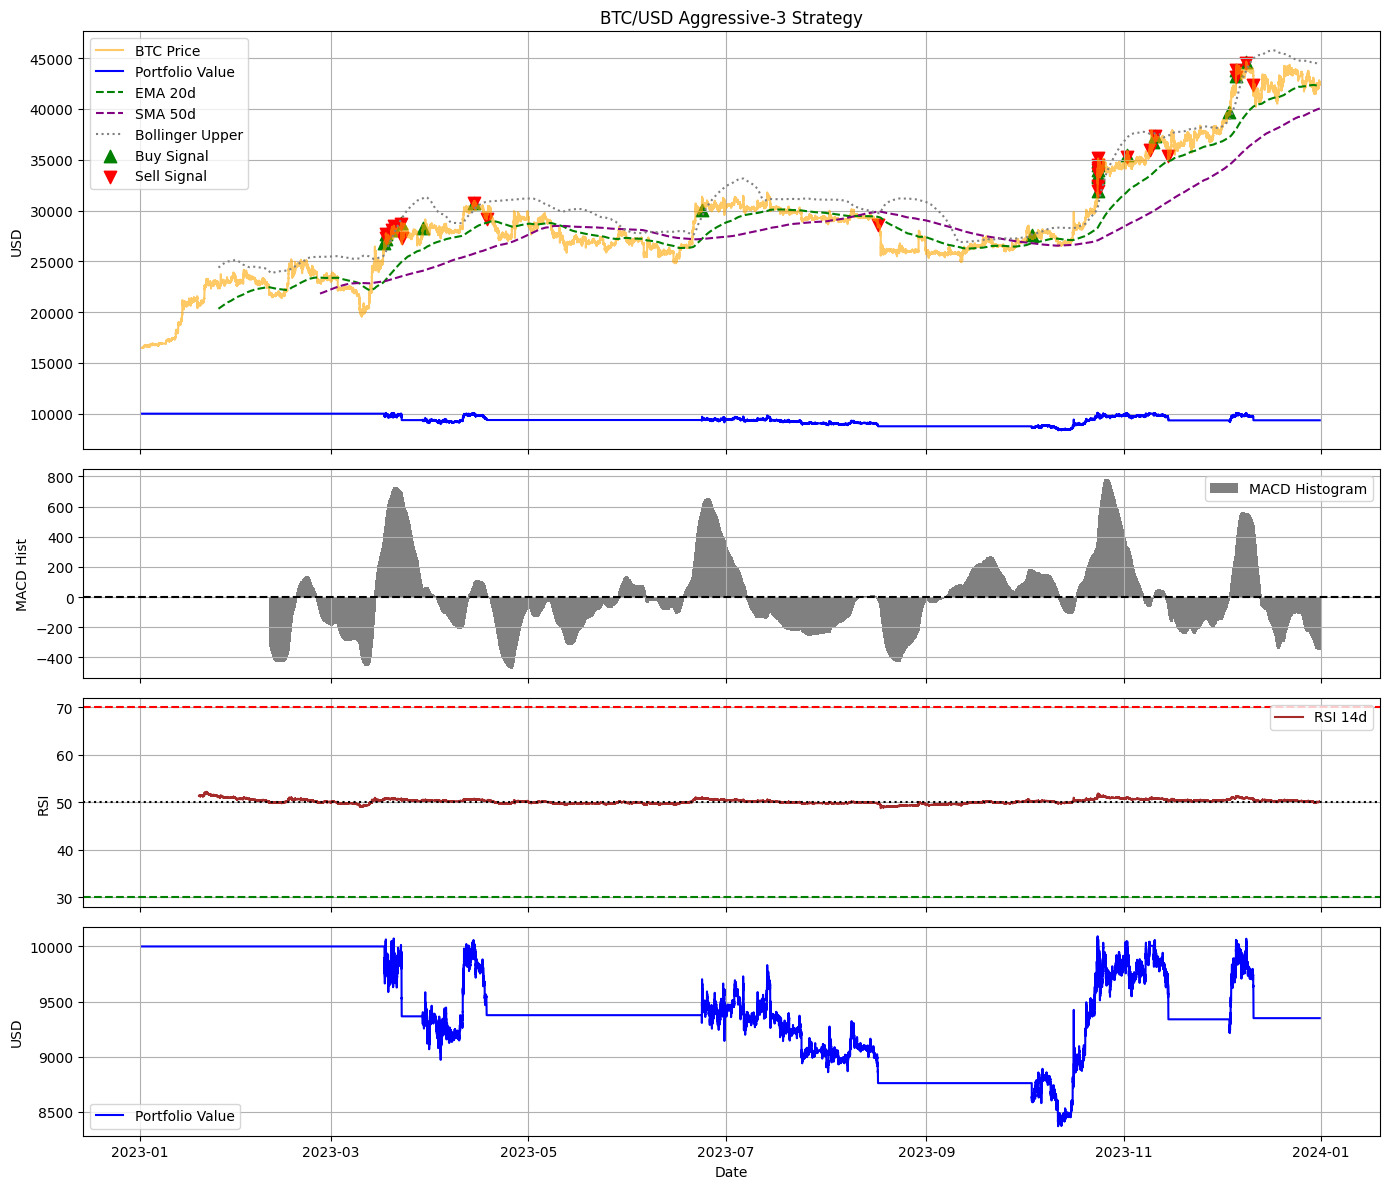

In [12]:
plot_full_strategy(df_v3, signals_v3, title = 'BTC/USD Aggressive-3 Strategy')

In [48]:
trade_log_df.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/strategy/trade_log_agg_v2.csv', index=False)
trade_log_v3.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/strategy/trade_log_agg_v3.csv', index=False)

The best assumption of negative profit with high win rate is the fee constraint blocks the strategy to sell.

In [14]:
def run_agg_strategy_v3_no_fee_exit(df, initial_cash=10000, hold_period=5, sl_pct=0.05, tp_pct=0.10, fee_pct=0.0075):
    cash = initial_cash
    position = 0
    entry_price = 0
    hold_counter = 0
    portfolio = []
    signals = []
    trade_log = []
    in_trade = False
    entry_time = None

    for i in range(2, len(df)):
        row = df.iloc[i]
        prev1 = df.iloc[i - 1]
        prev2 = df.iloc[i - 2]

        # Entry logic
        if not in_trade:
            if (
                row['Close'] > row['ema_20d']
                and row['ema_20d'] > row['sma_50d']
                and prev1['macd_hist_12_26'] > 0 and prev2['macd_hist_12_26'] > 0
                and row['macd_hist_12_26'] > prev1['macd_hist_12_26']
                and row['rsi_14d'] > 45 and row['rsi_14d'] > prev1['rsi_14d']
            ):
                entry_price = row['Close']
                position = (cash * (1 - fee_pct)) / entry_price
                entry_time = row.name
                hold_counter = 0
                cash = 0
                in_trade = True
                signals.append((row.name, 'Buy', entry_price))

        # Exit logic
        elif in_trade:
            hold_counter += 1
            price_change = (row['Close'] - entry_price) / entry_price
            reasons = []

            if row['Close'] < row['ema_20d']:
                reasons.append('Close < EMA')
            if row['macd_hist_12_26'] < 0:
                reasons.append('MACD hist < 0')
            if row['rsi_14d'] < 40:
                reasons.append('RSI < 40')
            if row['Close'] > row['bb_upper_20d']:
                reasons.append('Price > BB Upper')
            if price_change <= -sl_pct:
                reasons.append('Stop Loss')
            if price_change >= tp_pct:
                reasons.append('Take Profit')
            if hold_counter >= hold_period:
                reasons.append('Hold Expired')

            if reasons:
                exit_price = row['Close']
                exit_cash = position * exit_price * (1 - fee_pct)
                pnl = exit_cash - initial_cash
                return_pct = (exit_cash - initial_cash) / initial_cash * 100
                duration = hold_counter

                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Exit Time': row.name,
                    'Exit Price': round(exit_price, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Duration': duration,
                    'Exit Reason': ', '.join(reasons)
                })

                cash = exit_cash
                position = 0
                in_trade = False
                signals.append((row.name, 'Sell', exit_price))

        # Portfolio update
        total_value = cash if not in_trade else position * row['Close']
        portfolio.append(total_value)

    df_result = df.iloc[2:].copy()
    df_result['portfolio_value'] = portfolio
    trade_log_df = pd.DataFrame(trade_log)
    return df_result, signals, trade_log_df

In [15]:
df_v3_adj, signals_v3_adj, trade_log_v3_adj = run_agg_strategy_v3_no_fee_exit(df)


In [54]:
summarize_portfolio(df_v3_adj, signals_v3_adj)
trade_log_v3_adj.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/strategy/trade_log_agg_v3_adj.csv', index=False)

Initial Capital          : $10,000.00
Final Portfolio Value    : $0.00
Net Profit               : $-10,000.00
Total Return             : -100.00%
Number of Trades         : 10796
Win Rate                 : 52.70%
Max Drawdown             : -100.00%
Sharpe Ratio             : -3.42


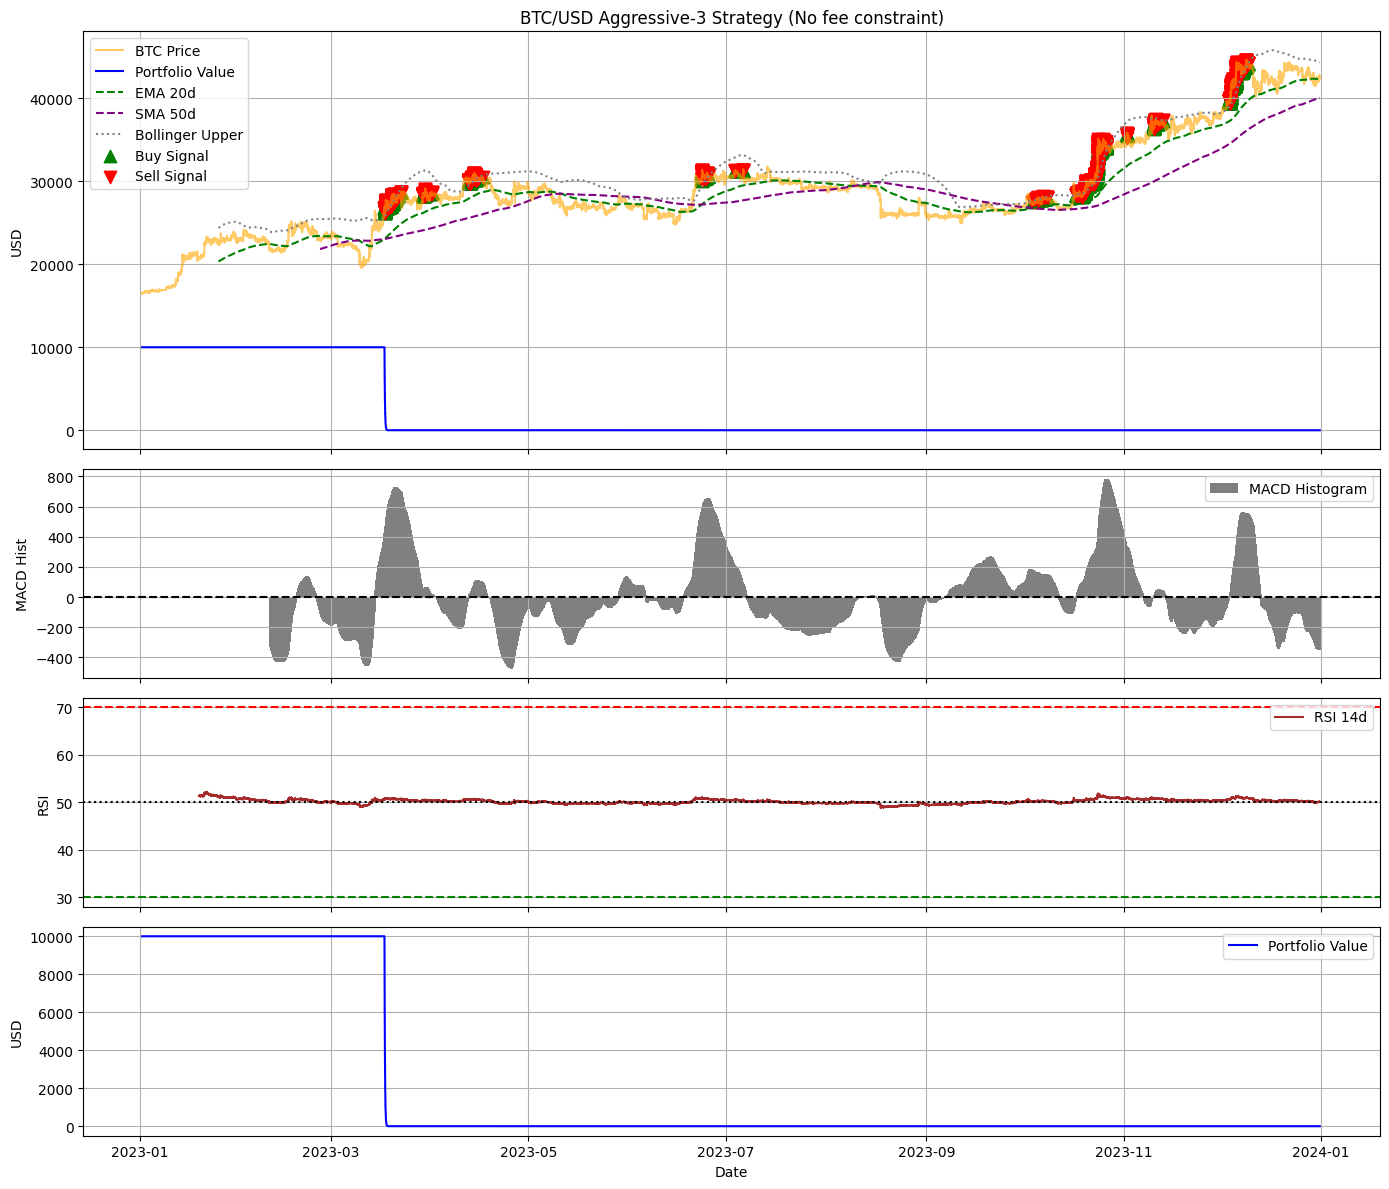

In [16]:
plot_full_strategy(df_v3_adj, signals_v3_adj, title = 'BTC/USD Aggressive-3 Strategy (No fee constraint)')

## v3 & v3 no fee Loss Reason Analysis
### Exit Reason: Price > BB under
Started from 3/17/23, the price frequently goes above BB upper, so it frequently triggered the strategy to sell. Most durations do not bigger than 1 period, so the loss the majorly comes from transaction fees.

### Further Steps:
Consider dropping price > BB upper for now, or use combined strategy to define exit signal, like combining it with MACD turning point and RSI trends. 

## v3 Strategy Stable Version
### ENTRY CONDITIONS (All must be true):
EMA_20d > SMA_50d
- Confirms trend direction

MACD Line crosses above Signal Line (bullish crossover)
- Confirms bullish momentum shift

RSI_14d is rising over last N bars
- e.g., RSI_14d[t] > mean(RSI_14d[t-3:t])
- Prevents entry on temporary RSI spikes

Hold-time Constraint: 1 window minimum
- Prevents instant exit right after entry

### EXIT CONDITIONS (All must be true):
MACD Line crosses below Signal Line (bearish crossover)
- Signals weakening trend

RSI_14d is falling (e.g., RSI_14d[t] < mean(RSI_14d[t-3:t]))
- Confirms loss of momentum

EMA_20d < SMA_50d
- Trend may have reversed

PnL > transaction fee threshold
- Sell only if actual gain > fee

OR price hits stop-loss / take-profit
- Stop-loss: -5%, Take-profit: +10%
(Override above exit logic for safety)

In [22]:
# Strategy: Aggressive V3 Stable
def run_agg_strategy_v3_stable(df, initial_cash=10000, sl_pct=0.05, tp_pct=0.10, fee_pct=0.0075, rsi_window=3, hold_period=1):
    cash = initial_cash
    position = 0
    entry_price = 0
    hold_counter = 0
    portfolio = []
    signals = []
    trade_log = []
    in_trade = False
    entry_time = None

    # Rolling RSI averages for trend slope checks
    df['rsi_rolling_mean'] = df['rsi_14d'].rolling(rsi_window).mean()

    for i in range(2 + rsi_window, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]
        prev2 = df.iloc[i - 2]

        # ENTRY conditions (all must be true)
        if not in_trade:
            if (
                row['ema_20d'] > row['sma_50d']
                or prev['macd_12_26'] < prev['macd_sig_12_26'] and row['macd_12_26'] > row['macd_sig_12_26']  # Bullish crossover
                or row['rsi_14d'] > row['rsi_rolling_mean']
            ):
                entry_price = row['Close']
                position = (cash * (1 - fee_pct)) / entry_price
                entry_time = row.name
                hold_counter = 0
                cash = 0
                in_trade = True
                signals.append((row.name, 'Buy', entry_price))

        # EXIT conditions (all must be true, or stop-loss / take-profit hit)
        elif in_trade:
            hold_counter += 1
            price_change = (row['Close'] - entry_price) / entry_price
            gain_over_fee = (row['Close'] * (1 - fee_pct)) > entry_price  # Gain must cover fee

            # Core exit signals
            macd_crossover = prev['macd_12_26'] > prev['macd_sig_12_26'] and row['macd_12_26'] < row['macd_sig_12_26']
            rsi_falling = row['rsi_14d'] < row['rsi_rolling_mean']
            trend_reversal = row['ema_20d'] < row['sma_50d']
            core_exit = macd_crossover and rsi_falling and trend_reversal and gain_over_fee and hold_counter >= hold_period

            # Forced exits
            stop_loss_hit = price_change <= -sl_pct
            take_profit_hit = price_change >= tp_pct

            if core_exit or stop_loss_hit or take_profit_hit:
                exit_price = row['Close']
                exit_cash = position * exit_price * (1 - fee_pct)
                pnl = exit_cash - initial_cash
                return_pct = (exit_cash - initial_cash) / initial_cash * 100
                duration = hold_counter

                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Exit Time': row.name,
                    'Exit Price': round(exit_price, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Duration': duration,
                    'Exit Reason': 'SL' if stop_loss_hit else 'TP' if take_profit_hit else 'Core'
                })

                cash = exit_cash
                position = 0
                in_trade = False
                signals.append((row.name, 'Sell', exit_price))

        total_value = cash if not in_trade else position * row['Close']
        portfolio.append(total_value)

    df_result = df.iloc[2 + rsi_window:].copy()
    df_result['portfolio_value'] = portfolio
    trade_log_df = pd.DataFrame(trade_log)
    return df_result, signals, trade_log_df


In [23]:
df_v3_stable, signals_v3_stable, trade_log_v3_stable = run_agg_strategy_v3_stable(df)

summarize_portfolio(df_v3_stable, signals_v3_stable)

trade_log_v3_stable.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/strategy/trade_log_agg_v3_stable.csv', index=False)

Initial Capital          : $10,000.00
Final Portfolio Value    : $12,587.57
Net Profit               : $2,587.57
Total Return             : 25.88%
Number of Trades         : 33
Win Rate                 : 50.00%
Max Drawdown             : -32.23%
Sharpe Ratio             : 0.02


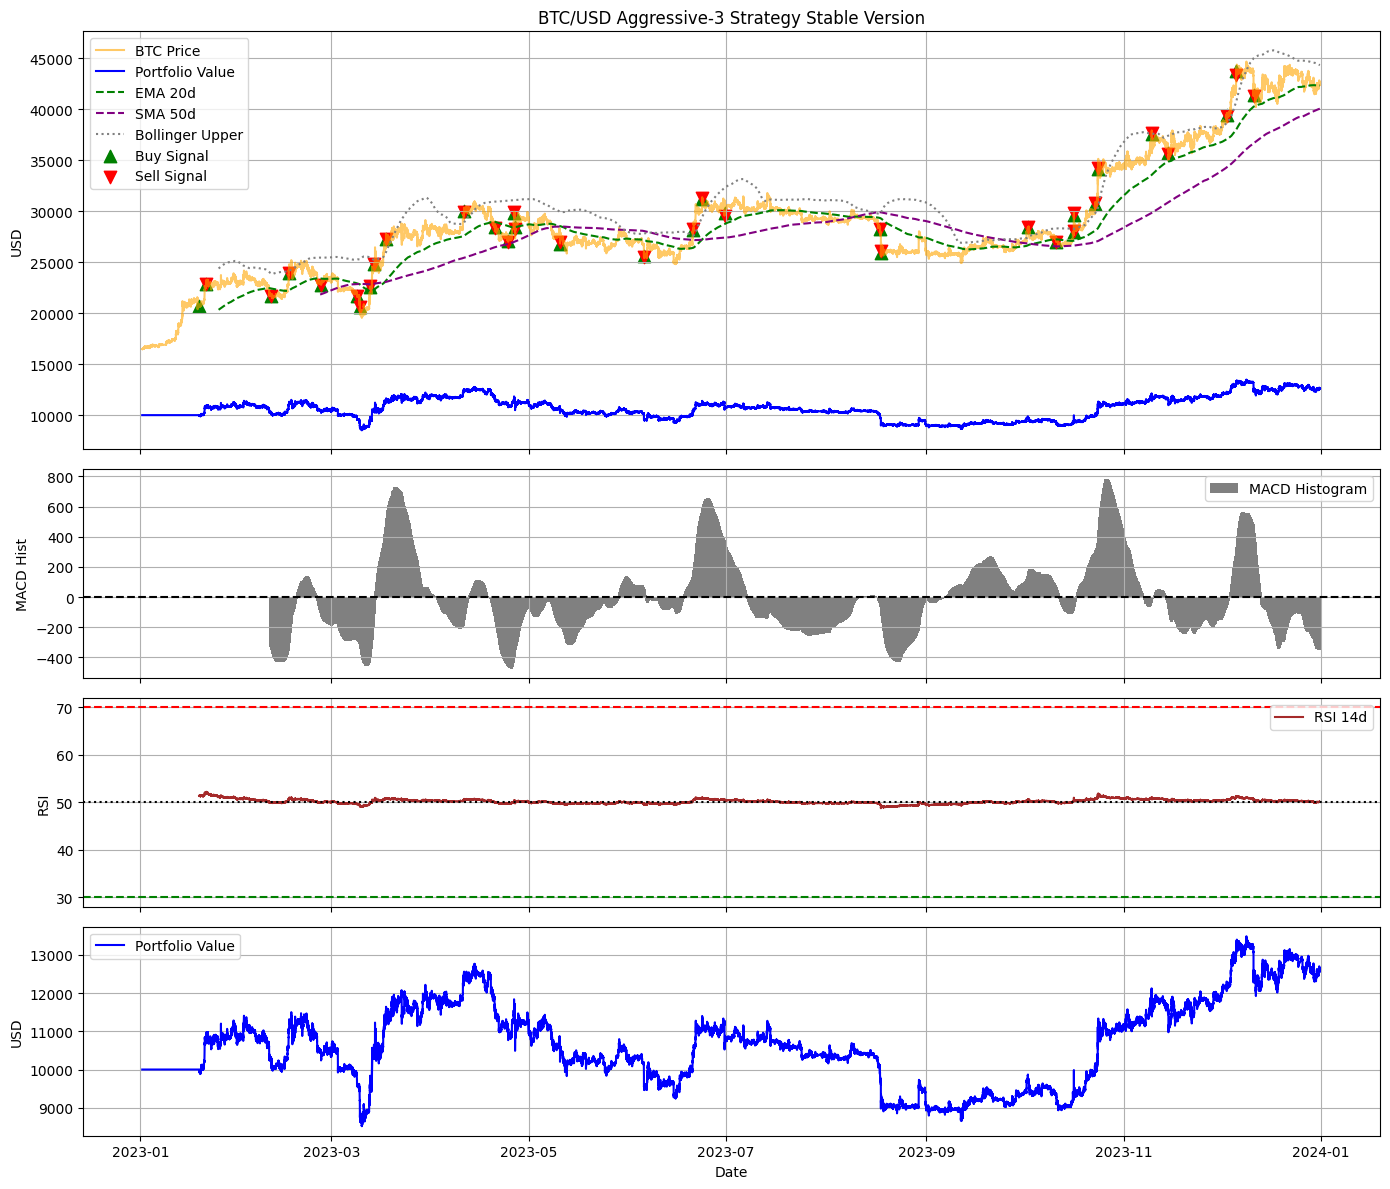

In [24]:
plot_full_strategy(df_v3_stable, signals_v3_stable, title = 'BTC/USD Aggressive-3 Strategy Stable Version')